In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F

In [13]:
# load the images and labels
images = np.load("./images.npy").copy().astype(np.float32)
labels = np.load("./labels.npy").copy().astype(np.int) # 0:apple 1:baseball 2:cookie 3:clock 4:fan

# prepare some constants
NUM_IMAGES, HEIGHT, WIDTH = images.shape
NUM_CLASSES = len(np.unique(labels))
NUM_OPT_STEPS = 5000 # default, may change in different experiments
NUM_HIDDEN = 100

# transform each image to a [height*width, 1] column vector
X = images.reshape(NUM_IMAGES, HEIGHT * WIDTH) 
Y = labels

# mean normalization on image data (mean = 0.0 and var = 1.0)
mean = X.mean()
s = X.std()
X = (X - mean) / s

# separate training, cross-validation and testing data (40000:5000:5000), all FloatTensors
train_X, cross_X, test_X = X[:40000], X[40000:45000], X[45000:] 
train_Y, cross_Y, test_Y = Y[:40000], Y[40000:45000], Y[45000:]

In [21]:
class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(16, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        # reshapes our vectors back into images
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1) # unsqueeze(dim) -- Returns a new tensor with a dimension 
                                                   # of size one inserted at the specified position.
                                                   # (the new dim is at 1st dim, which is the channel. Since input 
                                                   #  is absolutely 1 channel image, this new dim len should be 1)
        # two convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        # averages each channel spatially, so that each ‘image’ ends up with a height and width of 1
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x

model = TooSimpleConvNN()

In [28]:
def train(batch_size, optimizer):
    """
    Taking a single optimization step using batch size randomly-chosen examples
    Args: 
        batch_size: int 
        optimizer: torch.optim.XXX
    Returns:
        A int, the loss of training for 1 time using [batch_size] examples from training data
    """    
    
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_X.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_X[i]))
    y = autograd.Variable(torch.from_numpy(train_Y[i]))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y) #.cross_entropy(input, target, weight=None, size_average=True,
                                      #               ignore_index=-100, reduce=True)
                                      # input – Variable (N,C) where C = number of classes
                                      # target – Variable (N) where each value is 0 <= targets[i] <= C-1
    loss.backward()
    optimizer.step()
    return loss.data[0]

In [29]:
def accuracy(y, y_hat):
    """Compute training accuracy.
    Args:
       y: A 1-D int NumPy array.
       y_hat: A 1-D int NumPy array.
    Returns:
       A float, the fraction of time y[i] == y_hat[i].
    """
    return torch.mean((y == y_hat).float())   

In [30]:
def approx_train_accuracy():
    """
    Compute accuracy on random training data
    """
    # for a single batch of size 1000 to compute training accuracy
    random_size = 1000
    # test mode
    model.eval() 
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_X.shape[0], size=random_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_X[i])) 
    y = autograd.Variable(torch.from_numpy(train_Y[i]))
    y_hat = model(x) # (1000, NUM_CLASSES)
    y_hat = y_hat.max(dim = 1)[1] # get max on each row, and get the index of that max element
    accu = accuracy(y.data, y_hat.data)
    return accu

In [31]:
def val_accuracy():
    """
    Computes validation accuracy using a 
    single batch and all validation examples.
    """
    model.eval()
    x = autograd.Variable(torch.from_numpy(cross_X))
    y = autograd.Variable(torch.from_numpy(cross_Y))
    y_hat = model(x)
    y_hat = y_hat.max(dim = 1)[1]
    accu = accuracy(y.data, y_hat.data)
    return accu

In [32]:
def plotResult(train_accs, val_accs):
    """
    Plot training accuracy and validation 
    accuracy as a function of optimization step.
    Args:
        train_accs: float list, training accurasy
        val_accs: float list, validation accurasy
    """
    plt.plot(train_accs, 'r-')
    plt.plot(val_accs, 'b-')
    plt.title("training(red) accuracy vs validation(blue) accuracy - step")
    plt.show()

In [34]:
def train_and_predict(batch_size=1, num_steps=NUM_OPT_STEPS, 
                      opt=torch.optim.SGD, learning_rate=1e-3,
                      show_loss=True, show_curve=True):
    """
    Train the model 
    Args:
        batch_size: batch_size of traiing data in each training step, default=1;
        num_steps: number of training times, defult=5000;
        opt: optimizer, default is SGD;
        lr: learning rate, default=0.001;
        show_loss: if print the loss during training;
        show_curve: if plot the training/validation accuracy curve at the end;
    """
    optimizer = opt(model.parameters(), lr=learning_rate)
    
    train_accs, val_accs = [], [] # clear the previous results
    for i in range(num_steps):
        train(batch_size, optimizer)
        if i % 100 == 0:
            train_accs.append(approx_train_accuracy())
            val_accs.append(val_accuracy())
            if show_loss:
                print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))
    if show_curve:
        plotResult(train_accs, val_accs)
    return train_accs, val_accs

**Q: Above we mentioned that convolutional filters are applied to local image regions, with weights shared across regions. How does this compare to fully-connected neural networks?** 

A: Each convolutional filter share the same weights across all regions. Fully-connected nets use different weights for different nodes. In vision, if we consider each pixel of a input image as a node, then a convolutional filter uses a fixed-size kernel to scan over the whole picture (with some padding and strides). The weights for this feature detector is only related to the size of its kernel, but not related to where it is scanning. This means weights are shared among all regions for this current feature detector. However, in a fully-connected neural network the number of weights depend on the number of input nodes and output nodes. So if an input image is fully-connected to another layer by each node (pixel), then the number of parameters will be huge because the size of a high-resolution photo nowadays is very large. Thus, by using convolutional filters (networks), we can reduce the number of learnable model parameters dramatically and perform much faster.

     0  0.66  0.67
   100  0.66  0.65
   200  0.67  0.67
   300  0.65  0.67
   400  0.62  0.63
   500  0.63  0.67
   600  0.67  0.68
   700  0.67  0.68
   800  0.68  0.68
   900  0.68  0.67
  1000  0.69  0.68
  1100  0.68  0.69
  1200  0.70  0.68
  1300  0.68  0.69
  1400  0.70  0.69
  1500  0.69  0.70
  1600  0.67  0.69
  1700  0.68  0.69
  1800  0.72  0.70
  1900  0.68  0.70


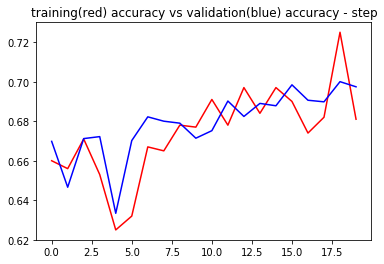

In [36]:
# Train this network for 5,000 steps using a batch size of 1, 
# using Adam as the optimizer with a learning rate of 0.001.
train_acc, val_acc = train_and_predict(batch_size=10, num_steps=2000, opt=torch.optim.Adam, 
                                       learning_rate=0.001, show_loss=True, show_curve=True)

### Experiments on batch size

size= 10
size= 20
size= 30
size= 40
size= 50
size= 60
size= 70
size= 80
size= 90
size= 100
size= 110
size= 120
size= 130
size= 140


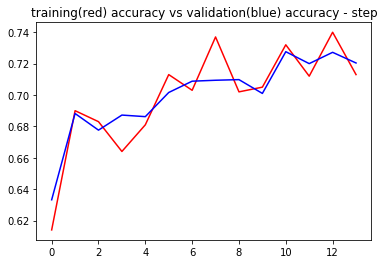

In [38]:
# result sets
all_train_accu = []
all_valid_accu = []

for size in range(10, 150, 10):
    print("size=", size)
    # clear param cache
    for m in model.children():
        m.reset_parameters()
        
    # train the model with diff batch sizes
    train_accs, val_accs = train_and_predict(batch_size=size, num_steps=2000, opt=torch.optim.Adam, 
                                            learning_rate=0.001, show_loss=False, show_curve=False)
    
    # get the last training and validation accuracy
    all_train_accu.append(train_accs[-1])
    all_valid_accu.append(val_accs[-1])

# plot the training and validation acuracy w.r.t different batch sizes
plt.plot(all_train_accu, 'r-')
plt.plot(all_valid_accu, 'b-')
plt.title("training(red) accuracy vs validation(blue) accuracy - step")
plt.show()